In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# QUICK CHECKS

In [ ]:
# quick environment check
!nvidia-smi
import torch, os
print("torch.cuda.is_available():", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())

Fri Dec  5 12:29:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Imports, config, and warning control

In [ ]:
!pip install -q transformers datasets accelerate --no-deps

In [ ]:
!pip install --upgrade protobuf==4.25.3 #first run this

In [ ]:
import os, random, logging, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'    # suppress TF messages

os.environ["TOKENIZERS_PARALLELISM"] = "false"

warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


# 2. Load the Dataset

In [ ]:
# Paths from Kaggle dataset
train_path = "/kaggle/input/ag-news-classification-dataset/train.csv"
test_path  = "/kaggle/input/ag-news-classification-dataset/test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Combine Title + Description into one text column
train_df["text"] = train_df["Title"].fillna("") + " " + train_df["Description"].fillna("")
test_df["text"]  = test_df["Title"].fillna("")  + " " + test_df["Description"].fillna("")

# Convert Class Index (1–4) → labels (0–3)
train_df["label"] = train_df["Class Index"] - 1
test_df["label"]  = test_df["Class Index"] - 1

label_names = ["World", "Sports", "Business", "Sci/Tech"]
num_labels = len(label_names)

print(train_df[["text", "label"]].head())
print("\nTrain shape:", train_df.shape, "Test shape:", test_df.shape)


                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2

Train shape: (120000, 5) Test shape: (7600, 5)


# WordCloud : Visualization

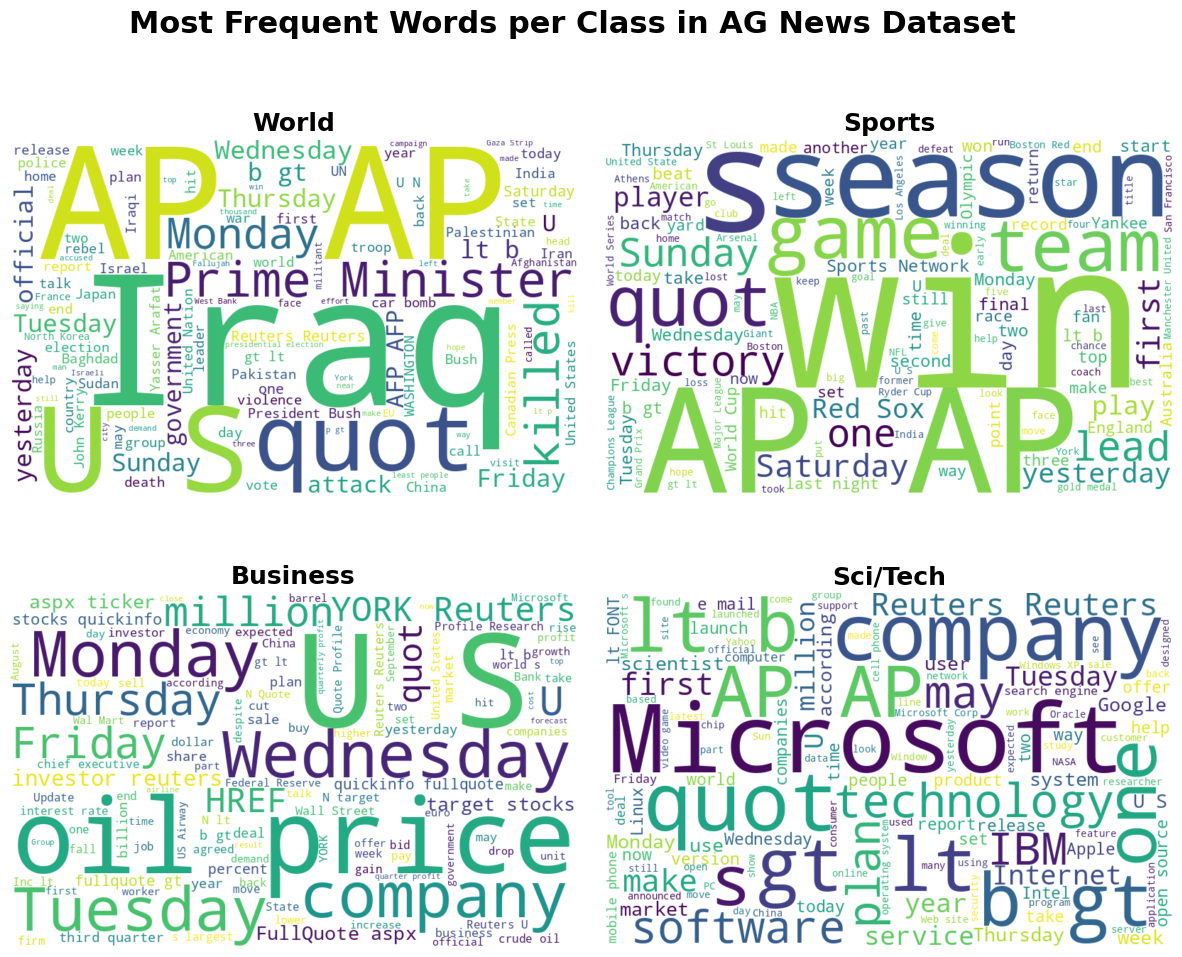

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all text per class
class_corpus = {i: " ".join(train_df[train_df["label"] == i]["text"]) for i in range(4)}

custom_stopwords = STOPWORDS.union({"said", "says", "say", "will", "new"})

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
axes = axes.flatten()

colors = ["#004C6D", "#007C9D", "#5BC0BE", "#9BC53D"]   # Matching theme across 4 plots

for idx, ax in enumerate(axes):
    wc = WordCloud(
        width=800,
        height=500,
        background_color="white",
        stopwords=custom_stopwords,
        max_words=120,
        colormap="viridis",    # professional colour scheme
        prefer_horizontal=0.9  # makes text orientation cleaner
    ).generate(class_corpus[idx])

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(label_names[idx], fontsize=18, fontweight="bold")

plt.suptitle("Most Frequent Words per Class in AG News Dataset", fontsize=22, fontweight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()


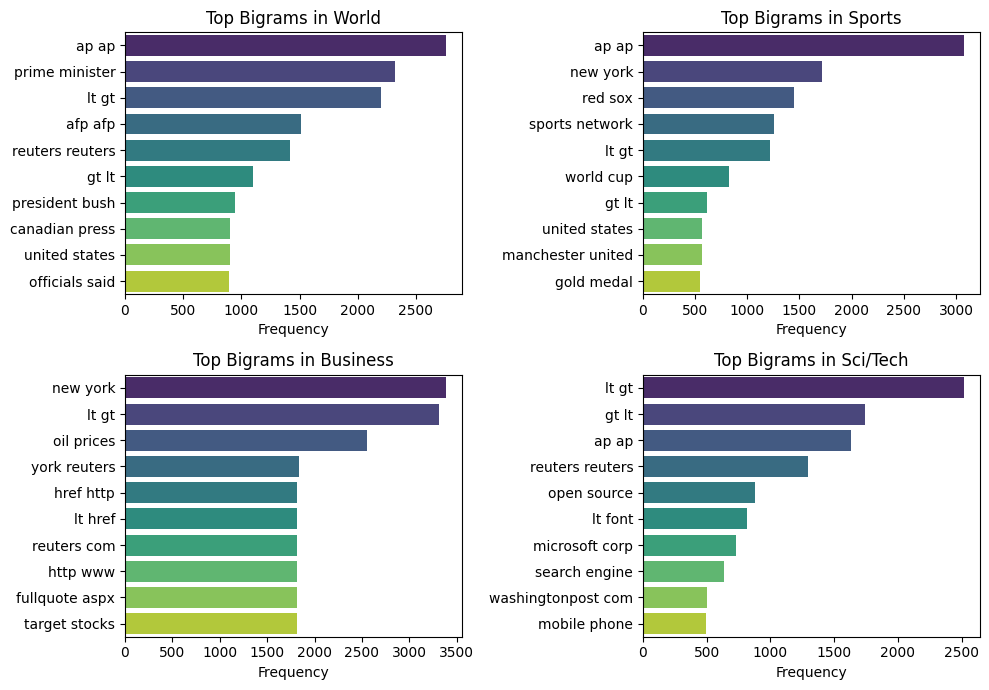

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

vectorizer = CountVectorizer(ngram_range=(2,2), max_features=10, stop_words="english")

fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # 2x2 grid
axes = axes.flatten()  # flatten to loop easily

for i, name in enumerate(label_names):
    text = train_df[train_df["label"] == i]["text"]
    X = vectorizer.fit_transform(text)
    freqs = np.array(X.sum(axis=0)).flatten()
    bigrams = vectorizer.get_feature_names_out()

    df = pd.DataFrame({"bigram": bigrams, "freq": freqs}).sort_values("freq", ascending=False)

    sns.barplot(
        x="freq", y="bigram",
        data=df,
        palette="viridis",
        ax=axes[i]
    )
    axes[i].set_title(f"Top Bigrams in {name}")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()


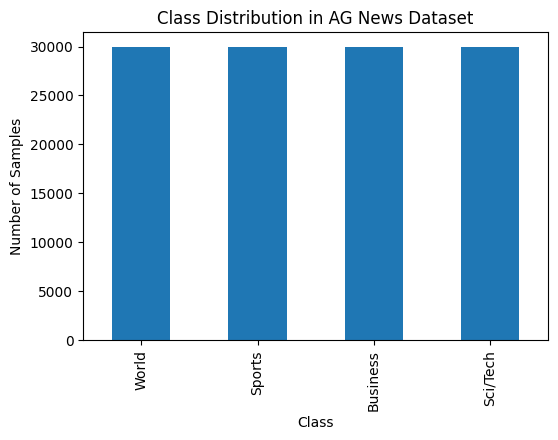

In [ ]:
train_df["label"].value_counts().sort_index().plot(kind="bar", figsize=(6,4))
plt.xticks([0,1,2,3], label_names)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in AG News Dataset")
plt.show()

# 3. Train/Validation split and convert to HF Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Stratified train/validation split
train_df_split, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=SEED,
)

print("Train split:", train_df_split.shape)
print("Val split:", val_df.shape)

# Convert pandas → Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_split[["text", "label"]].reset_index(drop=True))
val_dataset   = Dataset.from_pandas(val_df[["text", "label"]].reset_index(drop=True))
test_dataset  = Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True))

datasets_hf = DatasetDict(
    {
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset,
    }
)

datasets_hf


Train split: (108000, 5)
Val split: (12000, 5)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

# 4. Tokenize text with RoBERTa tokenizer

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

max_length = 128  # max tokens per example

def preprocess_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=False,       # padding later by DataCollator
        max_length=max_length,
    )

encoded_datasets = datasets_hf.map(
    preprocess_function,
    batched=True,
    remove_columns=["text"],   # keep tokenized fields + label
)

encoded_datasets


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

# 5. Load RoBERT classification model

In [ ]:
from transformers import AutoModelForSequenceClassification

id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

model.to(device);


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

# 6. Data collator (dynamic padding)

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 7. Define metrics (accuracy + macro F1)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}

# 8. TrainingArguments

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/kaggle/working/",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    greater_is_better=True,
    num_train_epochs=4,        # changed from 3 to 5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    fp16=True,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)



In [ ]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


# Sanity Check

In [ ]:

print("Model device (before train):", next(model.parameters()).device)  # expected: cpu now; Trainer will move it

Model device (before train): cuda:0


# 9. Training the Model

In [ ]:
trainer.train()

{'loss': 0.8021, 'grad_norm': 544308.5625, 'learning_rate': 9.926666666666668e-06, 'epoch': 0.02962962962962963}
{'loss': 0.321, 'grad_norm': 381814.5, 'learning_rate': 9.852592592592594e-06, 'epoch': 0.05925925925925926}
{'loss': 0.2957, 'grad_norm': 97315.28125, 'learning_rate': 9.778518518518519e-06, 'epoch': 0.08888888888888889}
{'loss': 0.2784, 'grad_norm': 563841.1875, 'learning_rate': 9.704444444444445e-06, 'epoch': 0.11851851851851852}
{'loss': 0.2451, 'grad_norm': 359475.40625, 'learning_rate': 9.63037037037037e-06, 'epoch': 0.14814814814814814}
{'loss': 0.2798, 'grad_norm': 205082.28125, 'learning_rate': 9.556296296296297e-06, 'epoch': 0.17777777777777778}
{'loss': 0.2599, 'grad_norm': 646768.0, 'learning_rate': 9.482222222222223e-06, 'epoch': 0.2074074074074074}
{'loss': 0.2399, 'grad_norm': 398062.90625, 'learning_rate': 9.408148148148148e-06, 'epoch': 0.23703703703703705}
{'loss': 0.2402, 'grad_norm': 281812.78125, 'learning_rate': 9.334074074074075e-06, 'epoch': 0.2666666

TrainOutput(global_step=13500, training_loss=0.15146732605828178, metrics={'train_runtime': 5872.5254, 'train_samples_per_second': 73.563, 'train_steps_per_second': 2.299, 'train_loss': 0.15146732605828178, 'epoch': 4.0})

# 10. Evaluate on test set

In [ ]:
from pprint import pprint
test_results = trainer.evaluate(encoded_datasets["test"])
print("Test metrics:", test_results)


{'eval_loss': 0.19211027026176453, 'eval_accuracy': 0.9525, 'eval_macro_f1': 0.9524944967923729, 'eval_runtime': 31.1953, 'eval_samples_per_second': 243.627, 'eval_steps_per_second': 7.629, 'epoch': 4.0}
Test metrics: {'eval_loss': 0.19211027026176453, 'eval_accuracy': 0.9525, 'eval_macro_f1': 0.9524944967923729, 'eval_runtime': 31.1953, 'eval_samples_per_second': 243.627, 'eval_steps_per_second': 7.629, 'epoch': 4.0}


In [ ]:
df = pd.DataFrame([test_results])
df = df.rename(columns={
    "eval_loss": "Loss",
    "eval_accuracy": "Accuracy",
    "eval_macro_f1": "Macro F1",
    "eval_runtime": "Runtime (sec)",
    "eval_samples_per_second": "Samples/sec",
    "eval_steps_per_second": "Steps/sec",
    "epoch": "Epoch"
})
print(df)

      Loss  Accuracy  Macro F1  Runtime (sec)  Samples/sec  Steps/sec  Epoch
0  0.19211    0.9525  0.952494        31.1953      243.627      7.629    4.0


# 11. Detailed classification report & confusion matrix

In [ ]:
preds_output = trainer.predict(encoded_datasets["test"])
logits = preds_output.predictions
y_test = preds_output.label_ids
y_pred = np.argmax(logits, axis=-1)
test_acc = accuracy_score(y_test, y_pred)
print(f"\n Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_names))

cm = confusion_matrix(y_test, y_pred)
cm



 Test Accuracy: 0.9525

Classification Report:

              precision    recall  f1-score   support

       World       0.97      0.96      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.93      0.92      0.93      1900
    Sci/Tech       0.92      0.94      0.93      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



array([[1825,    6,   37,   32],
       [   4, 1884,    6,    6],
       [  32,    8, 1744,  116],
       [  25,    9,   80, 1786]])

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision    recall  f1-score    support
World          0.967656  0.960526  0.964078  1900.0000
Sports         0.987939  0.991579  0.989756  1900.0000
Business       0.934119  0.917895  0.925936  1900.0000
Sci/Tech       0.920619  0.940000  0.930208  1900.0000
accuracy       0.952500  0.952500  0.952500     0.9525
macro avg      0.952583  0.952500  0.952494  7600.0000
weighted avg   0.952583  0.952500  0.952494  7600.0000


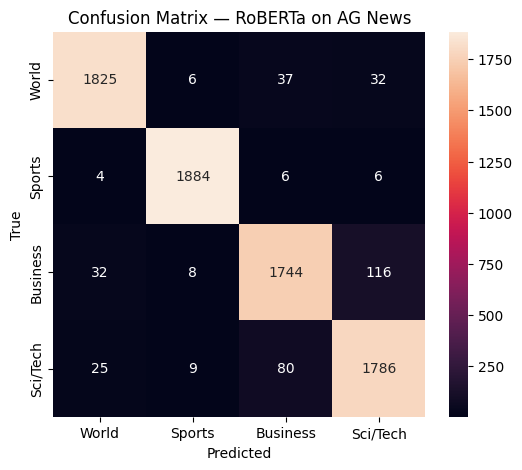

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — RoBERTa on AG News")
plt.show()


# 12. Extract Training Logs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = pd.DataFrame(trainer.state.log_history)
log_history.tail(10)   # optional preview


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_macro_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
131,0.0960,7.271913e+05,4.451852e-07,3.822222,12900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,0.0981,1.211820e+06,3.711111e-07,3.851852,13000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,0.1050,1.640891e+06,2.970370e-07,3.881481,13100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,0.0977,1.094602e+06,2.229630e-07,3.911111,13200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,0.1142,9.144021e+05,1.488889e-07,3.940741,13300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0.1048,3.204215e+05,7.481481e-08,3.970370,13400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,0.1105,9.544381e+05,7.407407e-10,4.000000,13500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,NaN,NaN,NaN,4.000000,13500,0.191404,0.94975,0.949781,49.8751,240.601,7.519,NaN,NaN,NaN,NaN,NaN
139,NaN,NaN,NaN,4.000000,13500,NaN,NaN,NaN,NaN,NaN,NaN,5872.5254,73.563,2.299,2.322949e+16,0.151467
140,NaN,NaN,NaN,4.000000,13500,0.192110,0.95250,0.952494,31.1953,243.627,7.629,NaN,NaN,NaN,NaN,NaN


# 13. Training vs Validation Loss

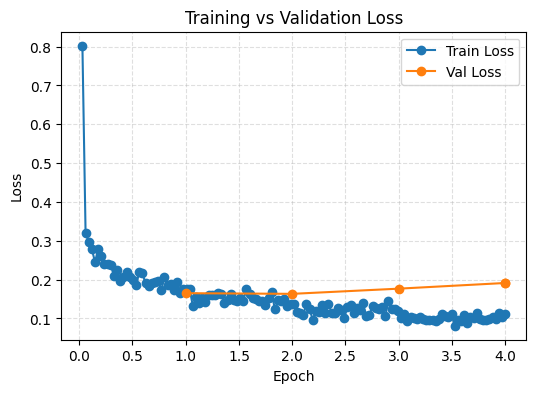

In [ ]:
# STEP 13A — Training vs Validation Loss curves
train_loss_logs = log_history[log_history["loss"].notna()][["epoch", "loss"]]
eval_loss_logs  = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(6,4))
plt.plot(train_loss_logs["epoch"], train_loss_logs["loss"], marker="o", label="Train Loss")
plt.plot(eval_loss_logs["epoch"], eval_loss_logs["eval_loss"], marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


# 14. Validation Accuracy Plot

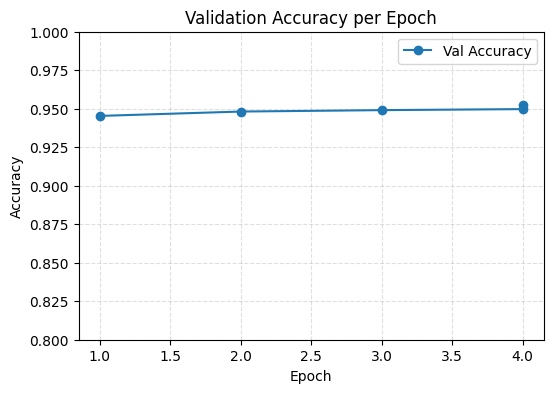

In [ ]:
# STEP 14 — Validation Accuracy curve
eval_acc_logs = log_history[log_history["eval_accuracy"].notna()][["epoch", "eval_accuracy"]]

plt.figure(figsize=(6,4))
plt.plot(eval_acc_logs["epoch"], eval_acc_logs["eval_accuracy"], marker="o", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.ylim(0.80, 1.00)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()
